In [24]:
import pandas as pd
import numpy as np
import sklearn as sk

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer
from sklearn import model_selection

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn import datasets
import sklearn as sk
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

In [26]:
# Read csv to dfCO
dfCO = pd.read_csv('co_statewide_2020_04_01.csv', header= 0, encoding= 'unicode_escape', dtype={'arrest_made': 'string',
                                                                                                'county_name': 'string',
                                                                                             'citation_issued': 'string',
                                                                                             'warning_issued': 'string',
                                                                                             'search_conducted': 'string'})
dfCO.head()

,raw_row_number,date,time,location,county_name,subject_age,subject_race,subject_sex,officer_id_hash,officer_sex,type,violation,arrest_made,citation_issued,warning_issued,outcome,contraband_found,search_conducted,search_basis,raw_Ethnicity
0,1947986|1947987,2013-06-19,NaN,"19, I70, 8",Mesa County,26.0,hispanic,male,b942632983,male,vehicular,Driver's Vision Obstructed Through Required Gl...,FALSE,TRUE,FALSE,citation,NaN,FALSE,NaN,H
1,1537576,2012-08-24,NaN,"254, H285, 11",Jefferson County,NaN,NaN,NaN,f3d4f46927,NaN,vehicular,NaN,FALSE,FALSE,FALSE,NaN,NaN,FALSE,NaN,NaN
2,1581594,2012-09-23,NaN,"115, I76, 13",Logan County,52.0,white,male,6e49e2fbc8,male,vehicular,Speeding (10-19 MPH Over the Maximum 75 MPH Li...,FALSE,FALSE,TRUE,warning,NaN,FALSE,NaN,W
3,1009205,2011-08-25,NaN,"197, H85, 47",Douglas County,32.0,white,female,eaea851669,NaN,vehicular,Speeding (10-19 MPH Over Prima Facie Limit *),FALSE,TRUE,FALSE,citation,NaN,FALSE,NaN,W
4,1932619,2013-06-08,NaN,"107, H287, 45",Kiowa County,33.0,hispanic,male,d18e34d749,male,vehicular,Failed to Drive in Single Lane (Weaving),FALSE,FALSE,TRUE,warning,NaN,FALSE,NaN,H


In [27]:
# Pick 100,000 random samples to reduce computation time.
#dfCO = dfCO.sample(n=100000)

In [28]:
# Drop redundant features, drop na.
df2 = dfCO.drop(['time', 'raw_row_number', 'location', 'officer_id_hash', 'type', 'search_basis','date','county_name','officer_sex','search_conducted', 'outcome','raw_Ethnicity','contraband_found'], axis = 1)
df2.dropna
df2.head()

,subject_age,subject_race,subject_sex,violation,arrest_made,citation_issued,warning_issued
0,26.0,hispanic,male,Driver's Vision Obstructed Through Required Gl...,FALSE,TRUE,FALSE
1,NaN,NaN,NaN,NaN,FALSE,FALSE,FALSE
2,52.0,white,male,Speeding (10-19 MPH Over the Maximum 75 MPH Li...,FALSE,FALSE,TRUE
3,32.0,white,female,Speeding (10-19 MPH Over Prima Facie Limit *),FALSE,TRUE,FALSE
4,33.0,hispanic,male,Failed to Drive in Single Lane (Weaving),FALSE,FALSE,TRUE


In [37]:
# Drop age > 100. Bad data.
df = df2[df2.subject_age < 100]
df=df.sample(n=100000)
df.head()
#fix the * differences
df['violation'].replace("Speeding (10-19 MPH Over Prima Facie Limit *)","Speeding (10-19 MPH Over Prima Facie Limit)",inplace=True)
df['violation'].replace("Speeding (5-9 MPH Over Prima Facie Limit *)","Speeding (5-9 MPH Over Prima Facie Limit)",inplace=True)

In [38]:
# create dummies for top 10 violations.
mask = df.isin(df['violation'].value_counts().head(10).index)
pd.get_dummies(df[mask])
cause = pd.get_dummies(df[mask]).iloc[:,4:]

In [39]:
# create sex and ciation_issued dummies
sex = pd.get_dummies(df.subject_sex)  # male = 1
sex = sex.drop(['female'], axis = 1).rename(columns={"male": "sex"})
citation = pd.get_dummies(df.citation_issued)   # True = 1
citation = citation.drop(['FALSE'], axis = 1).rename(columns={"TRUE": "citation"})
race = pd.get_dummies(df.subject_race)

# combine dummies with original df
df1 = pd.concat([df,race,sex,cause,citation], axis = 1)
df1.head()

,subject_age,subject_race,subject_sex,violation,arrest_made,citation_issued,warning_issued,asian/pacific islander,black,hispanic,...,violation_Careless Driving,violation_Displayed Expired Number Plates,violation_Failed to Drive in Single Lane (Weaving),violation_Operated Vehicle With Defective Headlamps,violation_Speeding (10-19 MPH Over Prima Facie Limit),violation_Speeding (10-19 MPH Over the Maximum 75 MPH Limit),violation_Speeding (5-9 MPH Over Prima Facie Limit),violation_Speeding (5-9 MPH Over the Maximum 75 MPH Limit),violation_Vehicle Had Only One Number Plate Attached,citation
2279597,44.0,white,male,Vehicle Had (No/Defective) License Plate Lamps,FALSE,FALSE,TRUE,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2483793,67.0,white,male,Vehicle Had Only One Number Plate Attached,FALSE,FALSE,TRUE,0,0,0,...,0,0,0,0,0,0,0,0,1,0
548004,19.0,white,female,Operated Vehicle With Defective Headlamps,FALSE,FALSE,TRUE,0,0,0,...,0,0,0,1,0,0,0,0,0,0
192015,52.0,white,male,Speeding (5-9 MPH Over Prima Facie Limit *)|Ve...,FALSE,FALSE,TRUE,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266867,23.0,white,male,Drove Vehicle When Safety Belt Not in Use,FALSE,TRUE,FALSE,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [40]:
# drop redundant features
df1.drop(columns=['subject_race', 'subject_sex', 'violation', 'arrest_made', 'citation_issued', 'warning_issued'], inplace=True)

In [41]:
# define inputs and target
inputs = df1[df1.columns[1:18]]
target = df1['citation']

In [42]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(90000, 17) (10000, 17) (90000,) (10000,)


In [43]:
#SVM Model

#TAKES AROUND 5 MINUTES TO RUN

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer
from sklearn import model_selection

scorerVar = make_scorer(f1_score, pos_label=1)

#create a model object
model = SVC()
#train our model
model.fit(X_train,y_train)
#evaluate the model 
y_hat=model.predict(X_test)
score=model.score(X_test,y_test)

#setup to get f-score and cv
svmvalscore = cross_val_score(model, X_test,y_test,scoring =scorerVar, cv = 5)


In [44]:
print("Score:", score)
#confusion matrix
print(confusion_matrix(y_test, y_hat))
#classification report
target_names = ['Citation given', 'Citation not given']
print(classification_report(y_test,y_hat,target_names=target_names))

Score: 0.7376
[[7251  111]
 [2513  125]]
                    precision    recall  f1-score   support

    Citation given       0.74      0.98      0.85      7362
Citation not given       0.53      0.05      0.09      2638

          accuracy                           0.74     10000
         macro avg       0.64      0.52      0.47     10000
      weighted avg       0.69      0.74      0.65     10000



In [45]:
df1.head()

,subject_age,asian/pacific islander,black,hispanic,other,unknown,white,sex,violation_Accident,violation_Careless Driving,violation_Displayed Expired Number Plates,violation_Failed to Drive in Single Lane (Weaving),violation_Operated Vehicle With Defective Headlamps,violation_Speeding (10-19 MPH Over Prima Facie Limit),violation_Speeding (10-19 MPH Over the Maximum 75 MPH Limit),violation_Speeding (5-9 MPH Over Prima Facie Limit),violation_Speeding (5-9 MPH Over the Maximum 75 MPH Limit),violation_Vehicle Had Only One Number Plate Attached,citation
2279597,44.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2483793,67.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
548004,19.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
192015,52.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
266867,23.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1


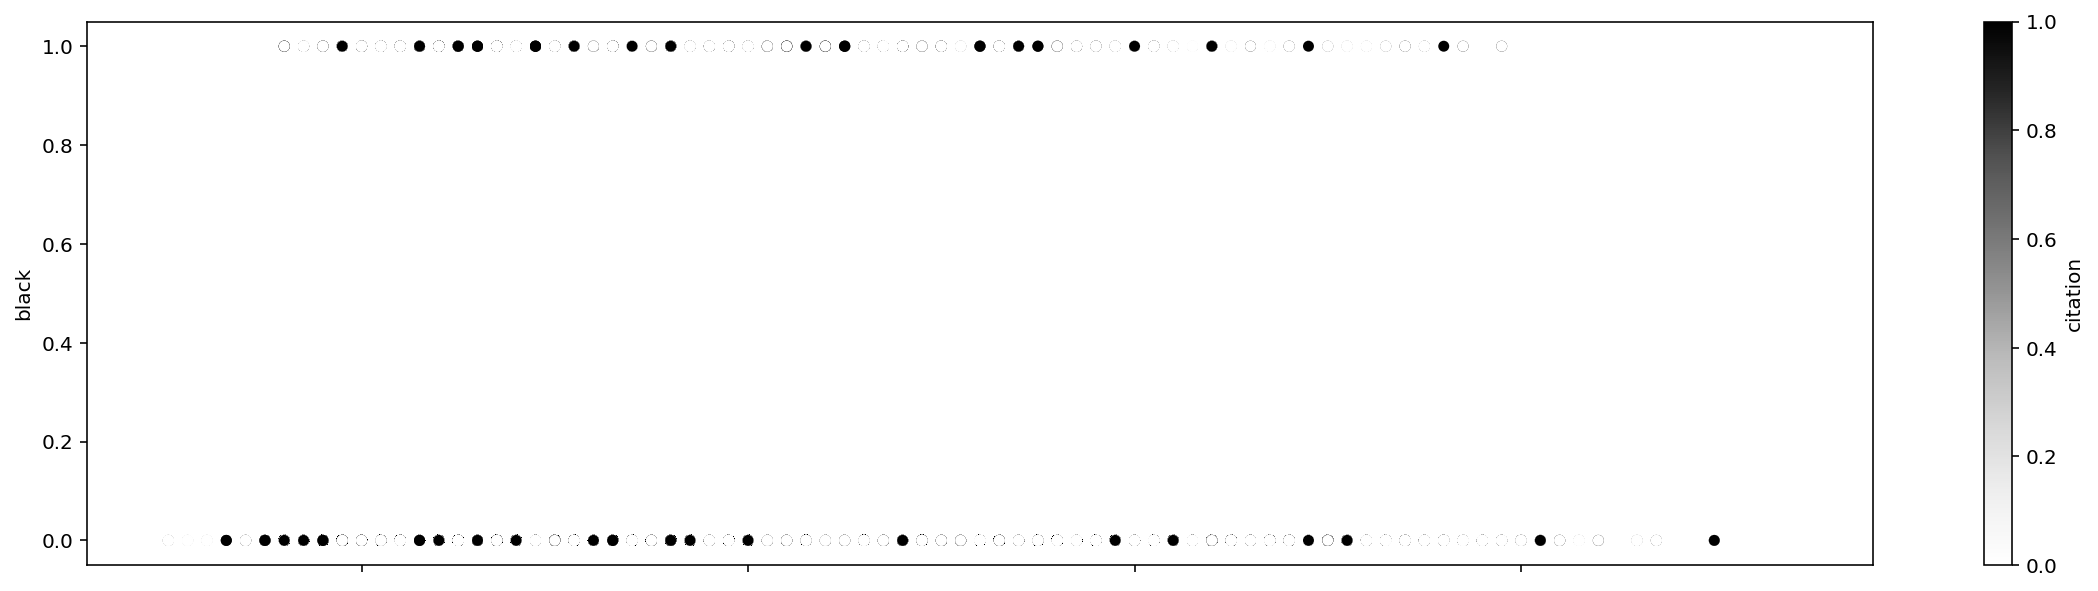

In [59]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


df1.plot.scatter("subject_age","black", c="citation",figsize=(20,5))
plt.xlabel("age")
#plt.ylabel()

plt.show()

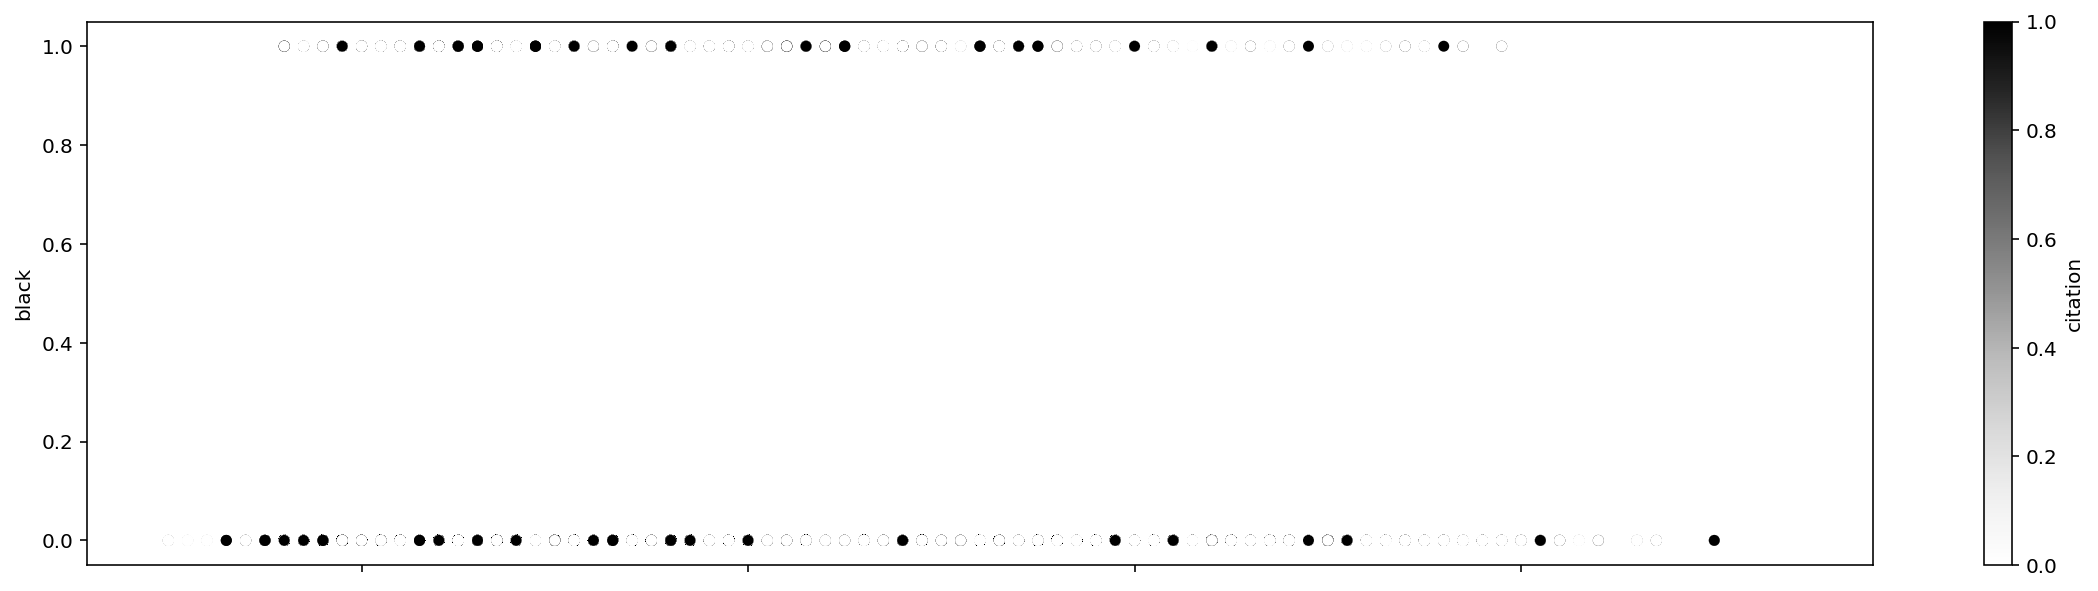

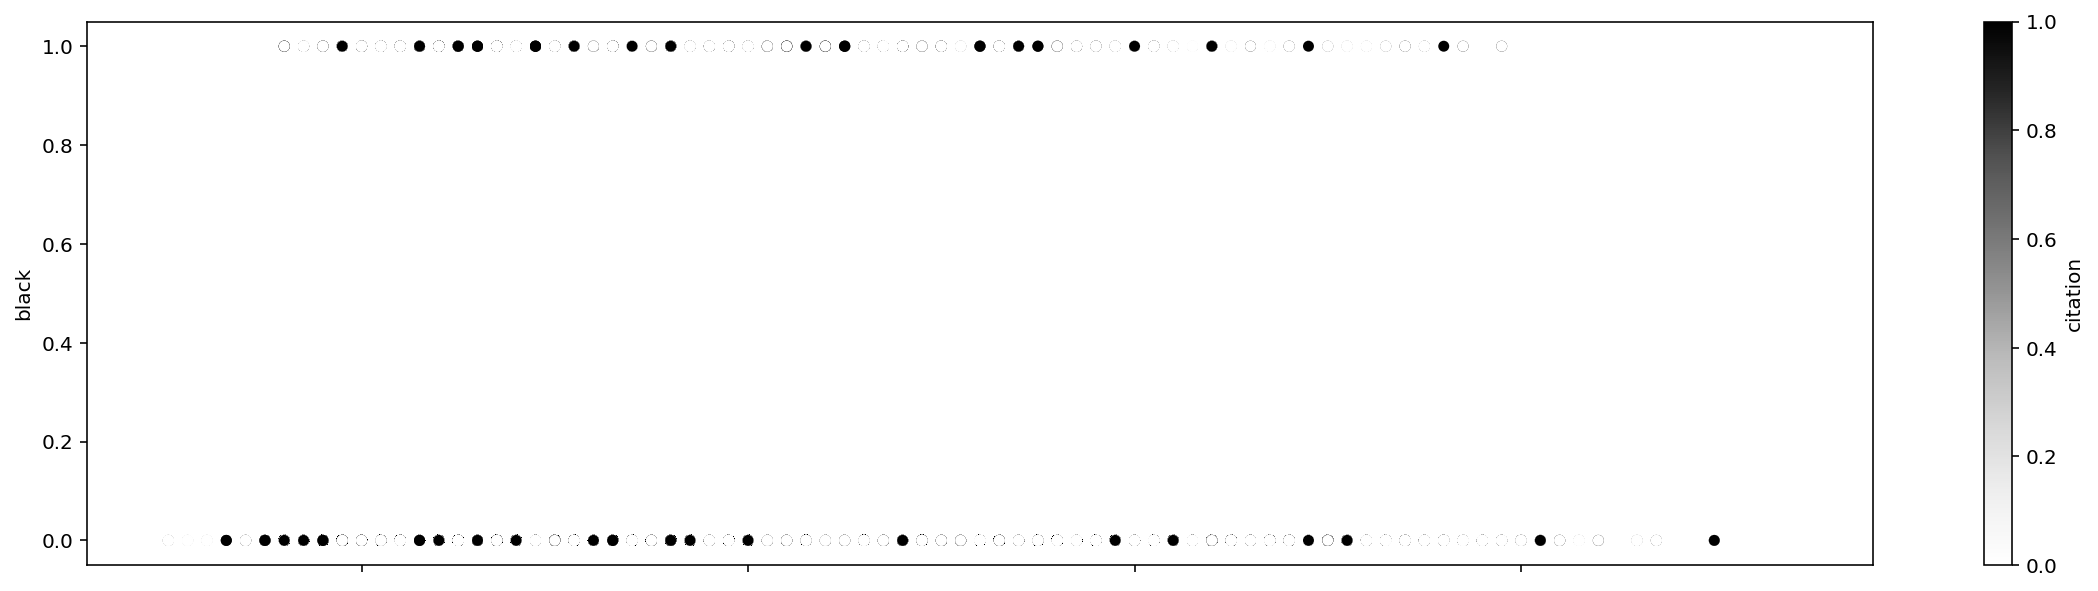

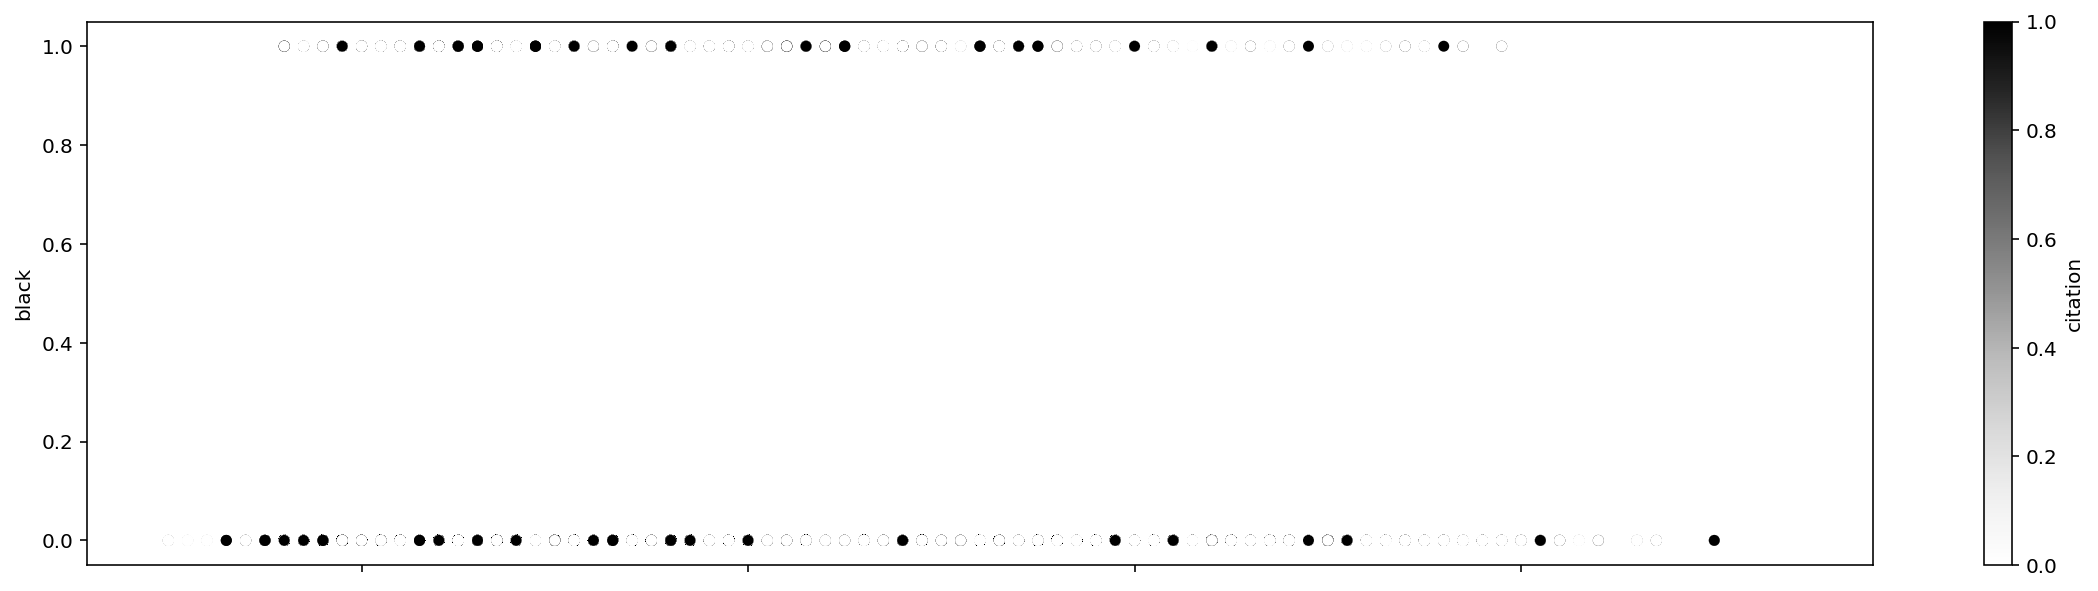

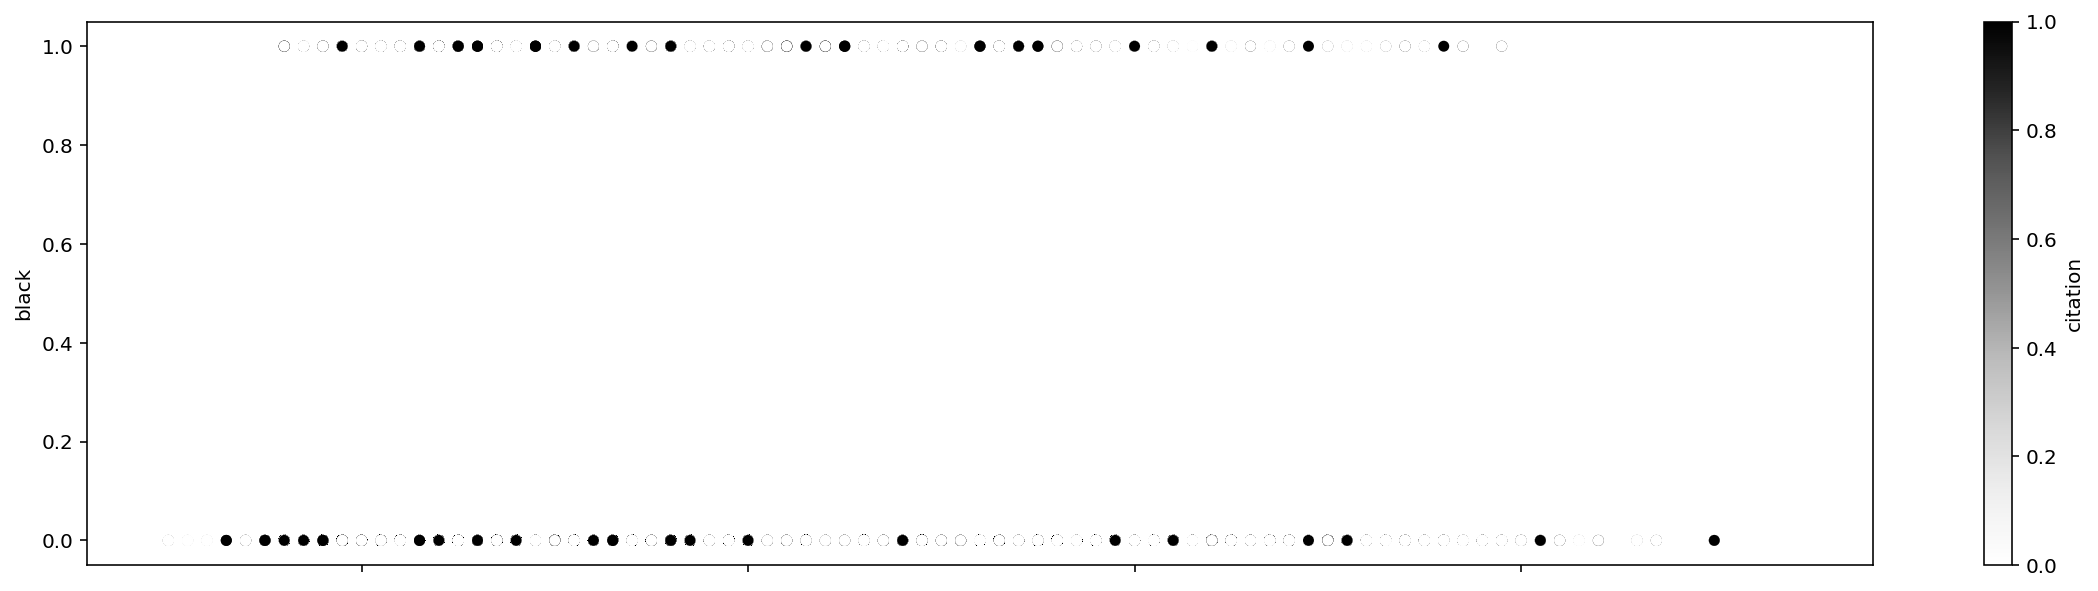

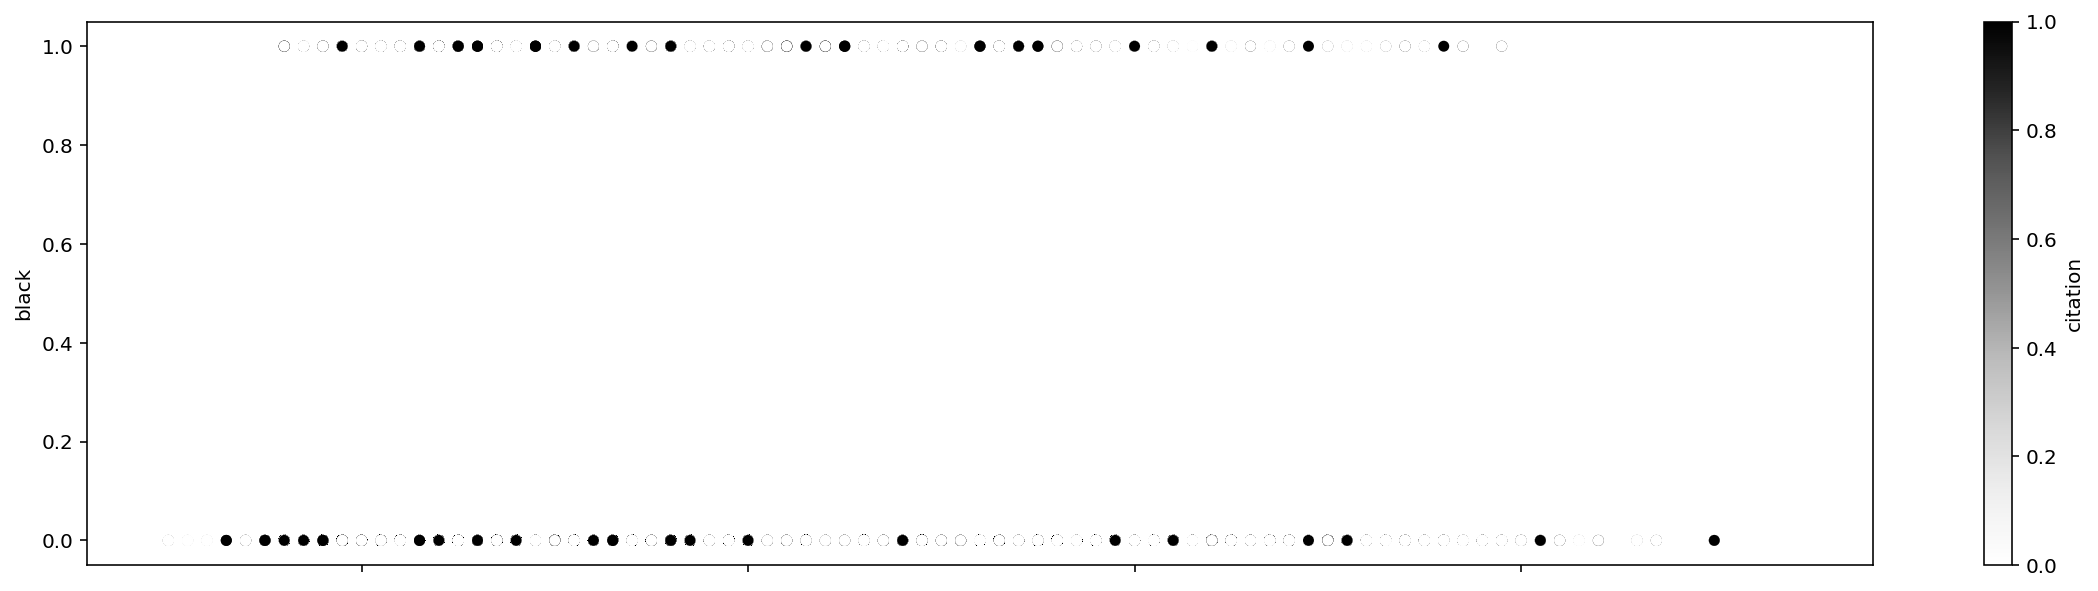

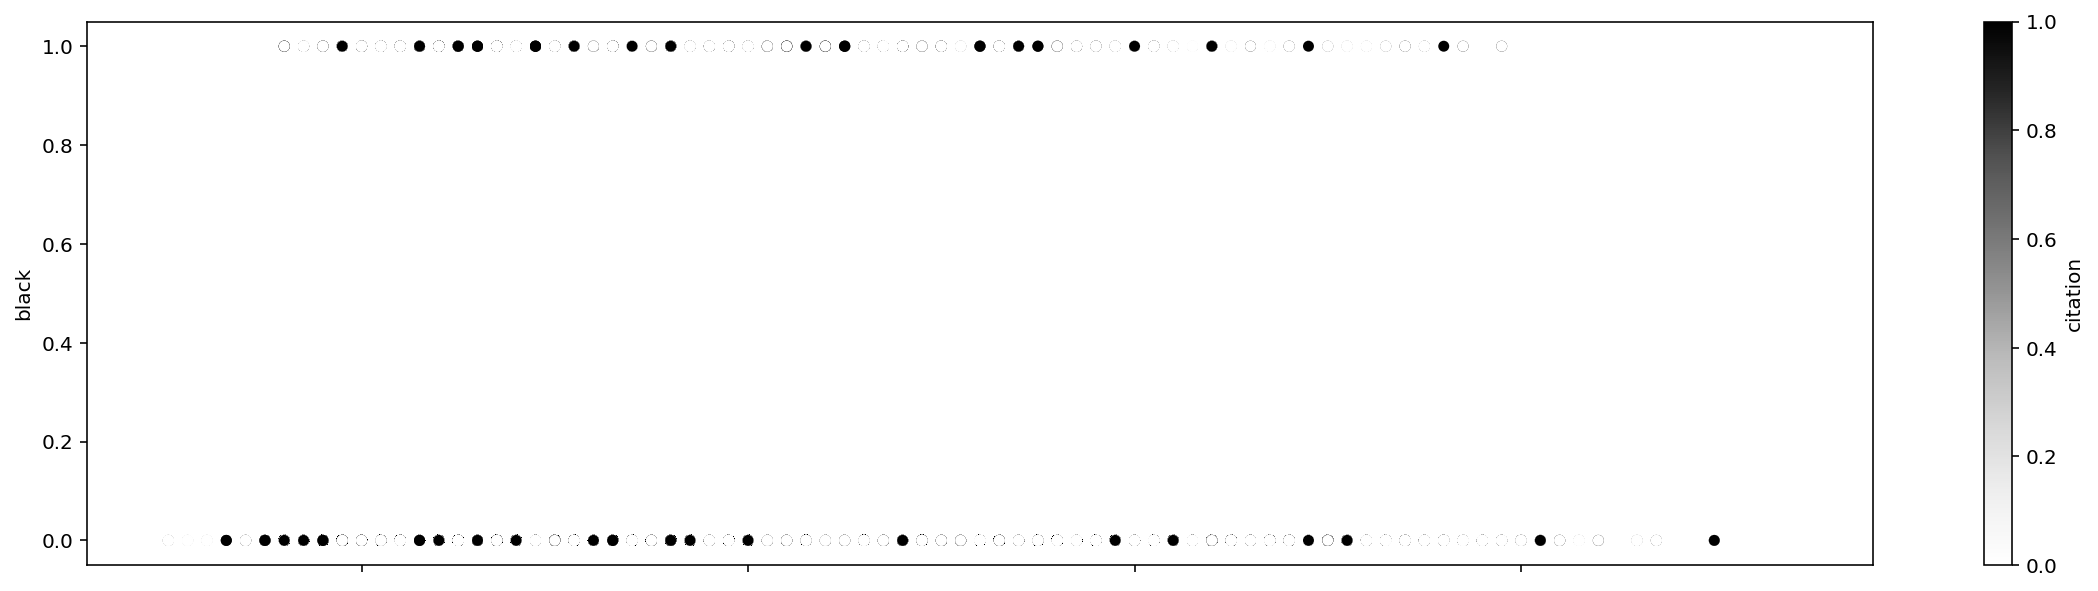

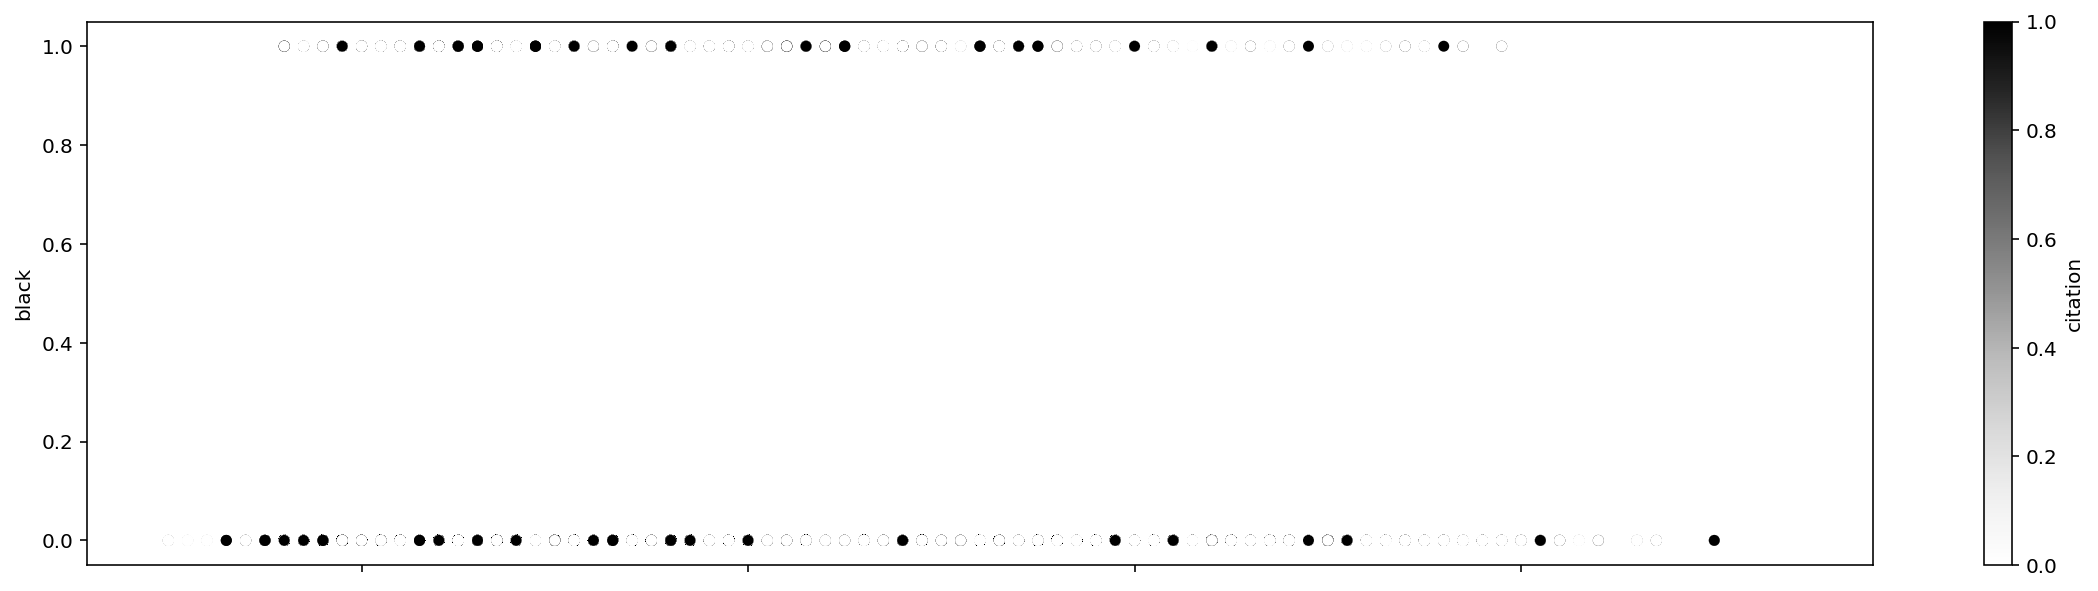

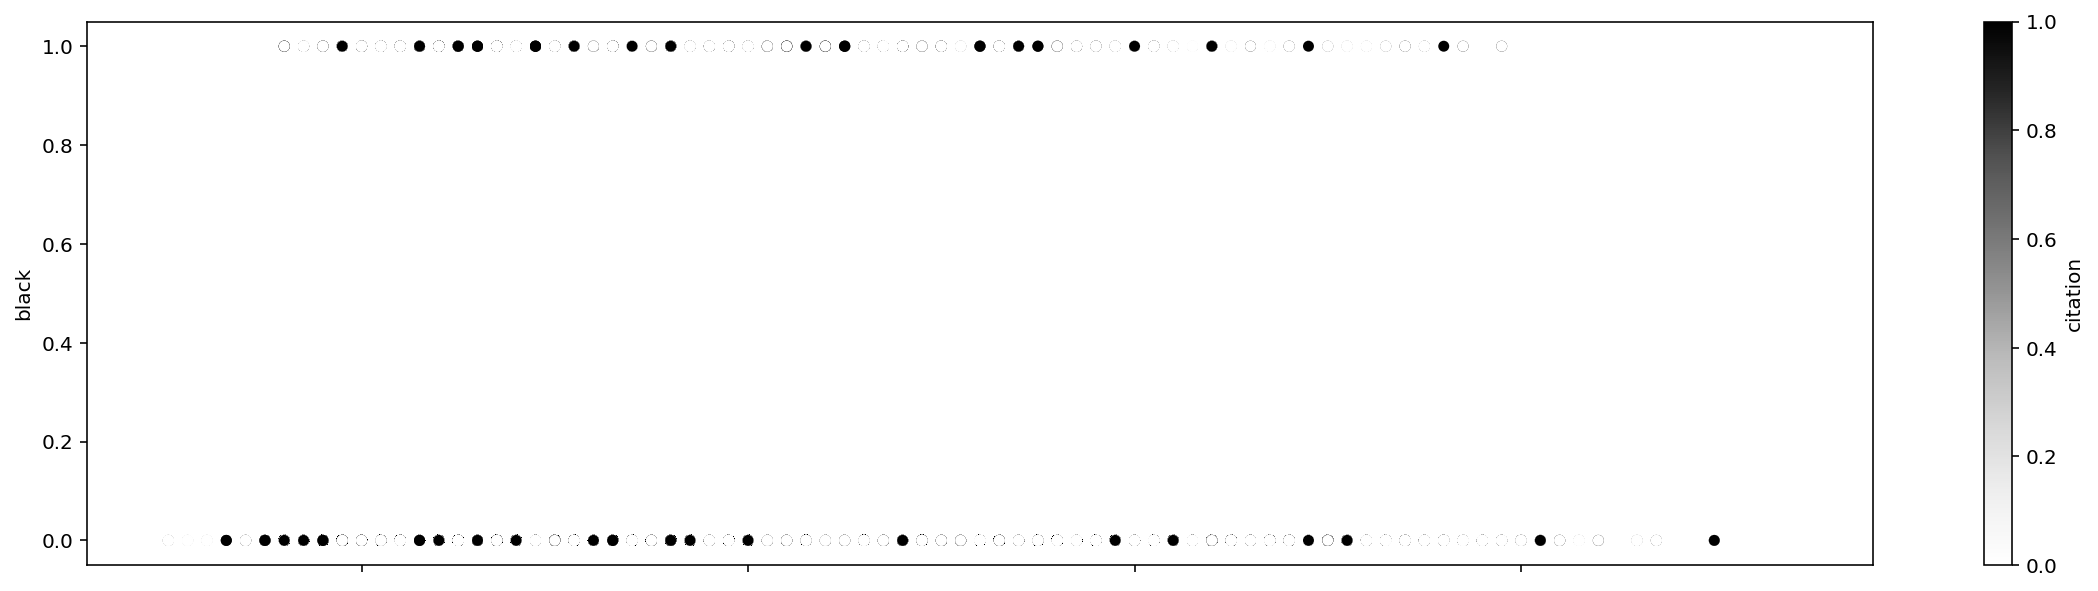

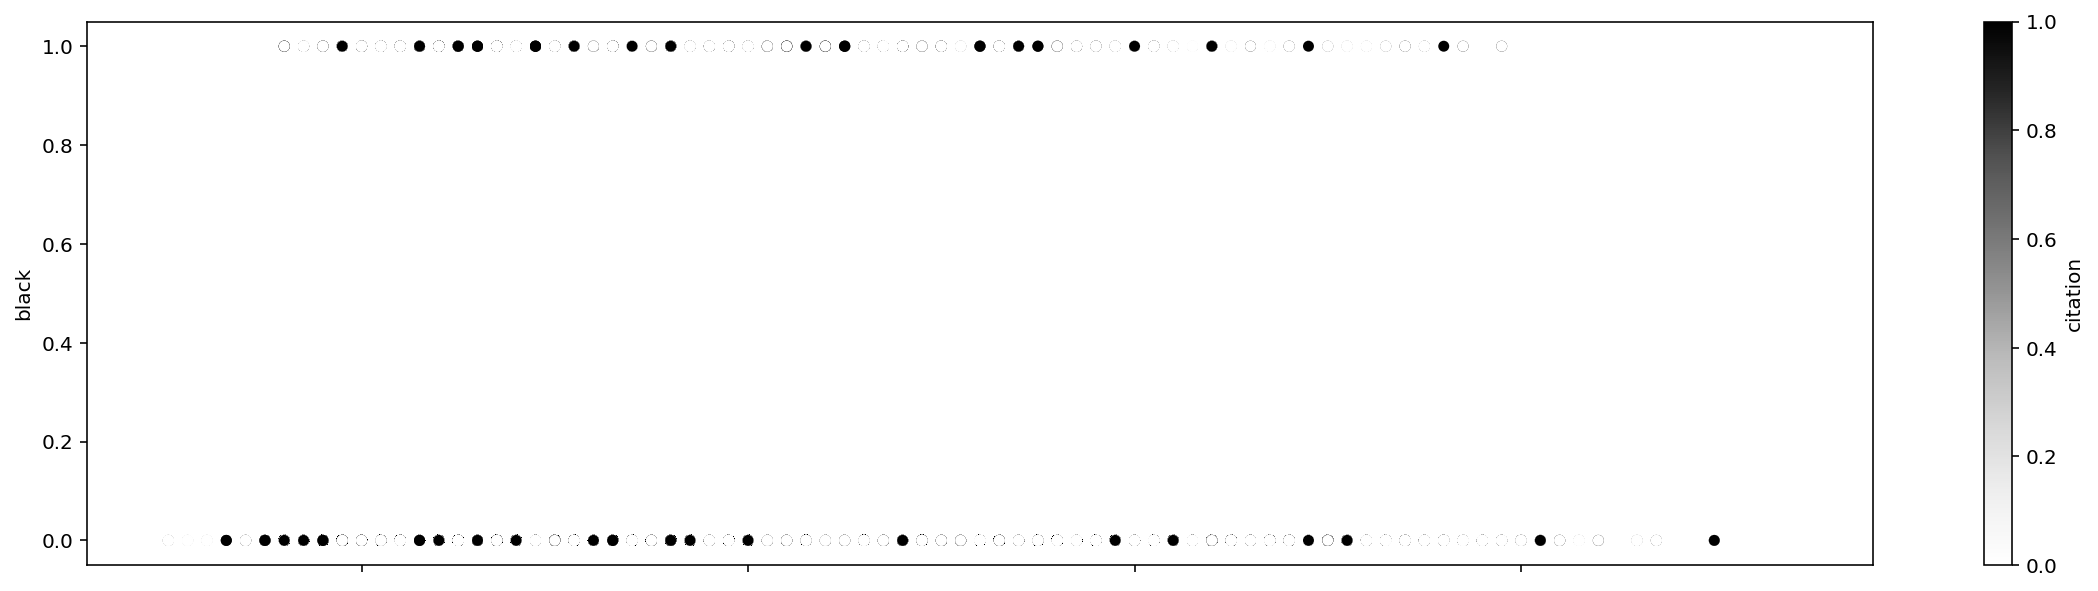

[0.4211925337290528, 0.43913368728013613, 0.5107883543354657, 0.5243280967148107, 0.579622919272867, 0.6279442638686307, 0.6560762119953707, 0.6916084045765032, 0.6945868253927848]


In [62]:
#KMeans Model

#TAKES 20 MINUTES TO RUN

from sklearn.metrics import silhouette_score
scores=[]
for k in range(2,11):
    km = KMeans(k)
    km.fit(inputs)
    prediction=km.predict(inputs)
    df1.plot.scatter("subject_age","black", c="citation",figsize=(20,5))
    #plt.xlabel(iris.feature_names[0])
    #plt.ylabel(iris.feature_names[1])
    #plt.title("k = " + str(k))
    plt.show()
    scores.append(silhouette_score(inputs,prediction))

print(scores)